# SnakeRL

The aim of this work is to develop an AI that can play Snake.

2.6.0


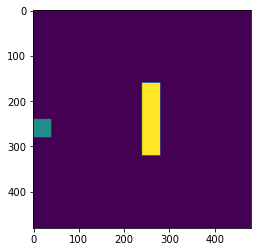

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from game import Snake
import numpy as np
import cv2
import random
from numpy import zeros, newaxis
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import rcParams

print(tf.__version__)

field_w = 12
field_h = 12
scale_percent = 40

game = Snake(field_w, field_h)

plt.imshow(game.generate_image(scale_percent=scale_percent))
plt.show()
plt.style.use('seaborn')

# Hyperparameters

In [2]:
epsilon = 0.99
learning_rate = 0.01
#learning_rate = 0.00025
epsilon_min = 0.01
width = game.generate_image().shape[0]
height = game.generate_image().shape[1]
batch_size = 32
gamma = 0.99
update_every_frame =  4
num_actions = 4
update_target_network = 10000
num_episodes = 100000
frame_count = 0

# Replay Memory

In [3]:
from collections import deque

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, value):
        """Save a transition"""
        self.memory.append(value)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Network

I used Huber as loss function and Adam as optimizer.

In [4]:
input_1 = [game.generate_image().reshape(width, height)]
input_2 = [game.generate_image().reshape(width, height)]
input_shape = np.vstack((input_1, input_2)).shape

loss_function = tf.keras.losses.Huber()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

print(input_shape)

def create_model():
  model = models.Sequential()
  model.add(layers.Conv2D(48, (3, 3), activation='relu',padding='same', input_shape=input_shape))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2),padding='same'))
  model.add(layers.Conv2D(192, (2, 2), activation='relu',padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2),padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(258, activation='relu'))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(258, activation='relu'))
  model.add(layers.Dropout(0.4))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(4, activation='linear'))
  #model.compile(loss=loss_function, optimizer=optimizer)
  return model

(2, 12, 12)


In [5]:
memory = ReplayMemory(100000)
av_fun = create_model()
target_av_fun = create_model()
target_av_fun.set_weights(av_fun.get_weights())
av_fun.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 2, 12, 48)         5232      
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 12, 48)         192       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 6, 48)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 6, 128)         55424     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 6, 128)         512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 3, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 3, 192)         9

# Training

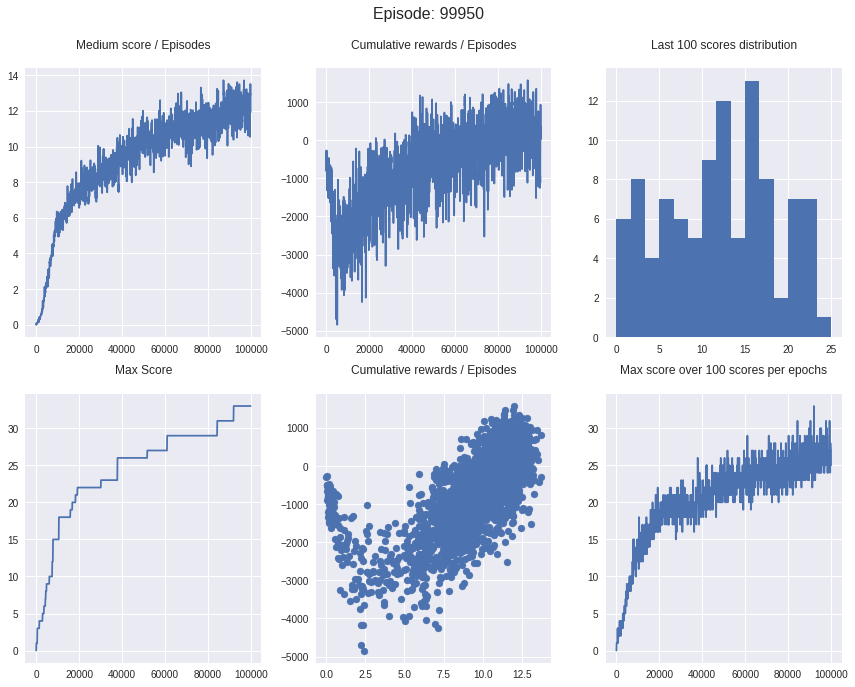

In [7]:
rewards_ep = 0
score_ep = []
general_score = []
max_score_local_tot = []
running_reward = 0
running_score = 0
episode_count = 0
episode_reward_history = []
reward_history_tot = []
max_score_tot = []
score_history_tot = []
ep_history_tot = []
frame_history_tot = []
general_max_history_tot = []
st_1 = [game.generate_image().reshape(width, height)]
next_state, _, _ = game.next_move(38)
st_2 = [next_state]
input_shape = np.vstack((st_1, st_2))

for i in range(0, num_episodes):
  env = Snake(field_w, field_h)
  rewards = 0
  episode_reward = 0
  # Play the game
  while not env.end:
    frame_count += 1
    st_1 = st_2
    st_2 = [env.generate_image().reshape(width, height)]
    st = np.vstack((st_1, st_2))
    if np.random.rand() < epsilon:
      action = random.randrange(4)
    else:
      action = np.argmax(av_fun.predict(np.array( [st,] ))[0]) 
    epsilon = max(epsilon * 0.9, epsilon_min)
    next_state, reward, done = env.next_move(action + 37)
    rewards += reward
    episode_reward += reward
    next_state_op = np.vstack((st_2, [next_state.reshape(width, height)]))
    memory.push((st, action, reward, next_state_op, done))
    
    if frame_count % update_every_frame == 0 and len(memory) > batch_size:
      minibatch = memory.sample(batch_size)
      state_sample = np.array([value[0] for value in minibatch])
      action_sample = [value[1] for value in minibatch]
      rewards_sample = [value[2] for value in minibatch]
      next_state_sample = np.array([value[3] for value in minibatch])
      done_sample = np.array([float(value[4]) for value in minibatch])
      future_rewards = target_av_fun.predict(next_state_sample)
      updated_q_values = rewards_sample + gamma * tf.reduce_max(future_rewards, axis=1)
      updated_q_values = updated_q_values * (1 - done_sample) - done_sample
      masks = tf.one_hot(action_sample, num_actions)

      with tf.GradientTape() as tape:
          # Train the model on the states and updated Q-values
          q_values = av_fun(state_sample)

          # Apply the masks to the Q-values to get the Q-value for action taken
          q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
          # Calculate loss between new Q-value and old Q-value
          loss = loss_function(updated_q_values, q_action)

          # Backpropagation
          grads = tape.gradient(loss, av_fun.trainable_variables)
          optimizer.apply_gradients(zip(grads, av_fun.trainable_variables))
          if frame_count % update_target_network == 0:
            # update the the target network with new weights
            target_av_fun.set_weights(av_fun.get_weights())
      
  # Update running reward to check condition for solving
  episode_reward_history.append(episode_reward)
  if len(episode_reward_history) > 100:
      del episode_reward_history[:1]
  running_reward = np.mean(episode_reward_history)

  episode_count += 1
  # Update running score to check condition for solving
  general_score.append(env.score)
  score_ep.append(env.score)
  if len(score_ep) > 100:
    del score_ep[:1]
  running_score = np.mean(score_ep)

  # Plotting
  if i % 50 == 0:
    clear_output()
    rcParams['axes.titlepad'] = 20 
    fig, axs = plt.subplots(2, 3,figsize=(12,10))
    fig.suptitle('Episode: {}'.format(episode_count - 1), fontsize=16)
    ep_history_tot.append(episode_count)
    max_score_local_tot.append(np.amax(np.array(score_ep)))
    score_history_tot.append(running_score)
    reward_history_tot.append(running_reward)
    frame_history_tot.append(episode_count)
    general_max_history_tot.append(np.amax(np.array(general_score)))

    axs[0, 0].title.set_text('Medium score / Episodes')
    axs[0, 1].title.set_text('Cumulative rewards / Episodes')
    axs[0,2].title.set_text('Last 100 scores distribution')
    axs[1, 0].title.set_text('Max Score')
    axs[1, 1].title.set_text('Cumulative rewards / Episodes')
    axs[1,2].title.set_text('Max score over 100 scores per epochs')

    axs[0, 0].plot(ep_history_tot, score_history_tot)
    axs[0, 1].plot(ep_history_tot, reward_history_tot)
    axs[0,2].hist(score_ep, bins=15)
    axs[1, 0].plot(ep_history_tot, general_max_history_tot)
    axs[1, 1].scatter(score_history_tot, reward_history_tot)
    axs[1,2].plot(ep_history_tot, max_score_local_tot)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Logging

In [8]:
import pandas as pd
stats = pd.DataFrame(np.column_stack([ep_history_tot, score_history_tot, reward_history_tot, general_max_history_tot, frame_history_tot]), 
                               columns=['Episode', 'Score', 'Rewards', 'Max Score', 'FrameCount'])
stats.to_csv("output.csv", index=False)
stats

,Episode,Score,Rewards,Max Score,FrameCount
0,1.0,0.000000,-280.000000,0.0,1.0
1,51.0,0.078431,-812.745098,1.0,51.0
2,101.0,0.060000,-529.600000,1.0,101.0
3,151.0,0.050000,-272.600000,1.0,151.0
4,201.0,0.050000,-489.600000,1.0,201.0
...,...,...,...,...,...
1995,99751.0,12.960000,-1124.600000,33.0,99751.0
1996,99801.0,12.880000,555.700000,33.0,99801.0
1997,99851.0,13.510000,930.300000,33.0,99851.0
1998,99901.0,12.860000,23.900000,33.0,99901.0


# Model

In [9]:
av_fun.save('snake_model.h5')

# Testing

In [12]:
list_score = []

for i in range(0, 200):
    field = Snake(12, 12)
    next_state, _, _ = field.next_move(38)
    st_2 = [next_state]
    while not field.end:
        st_1 = st_2
        st_2 = [field.generate_image().reshape(width, height)]
        st = np.vstack((st_1, st_2))
        res = np.argmax(av_fun.predict(np.array([st, ]))[0])
        field.next_move(37 + res)
    list_score.append(field.score)

print("Average score: {:.2f} \n Variance: {:.2f} \n Max Value: {}".format(np.mean(list_score), np.var(list_score), np.max(list_score)))

Average score: 9.55 
 Variance: 76.18 
 Max Value: 30
